In [3]:
import pandas as pd
df = pd.read_csv('/content/dataset_for_SI_clean (1).csv')
df.head()

,SI,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,log_IC50,log_CC50
0,7.00,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,...,0,0,0,0,0,0,3,0,0.572014,1.856738
1,0.72,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,...,0,0,0,0,0,0,3,0,5.415250,5.088474
2,1.30,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,0.062897,-0.257239,0.600000,...,0,0,0,0,0,0,0,0,4.683348,4.943576
3,2.00,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,0.062897,-0.398729,0.960000,...,0,0,0,0,0,0,0,0,2.774955,3.436430
4,0.77,2.584472,0.429649,0.429649,0.328539,36.564103,528.869,0.132160,-0.293073,0.564103,...,0,0,0,0,0,0,0,0,2.991130,2.744658



>>> Training LogisticRegression
Fitting 5 folds for each of 4 candidates, totalling 20 fits

>>> Training RandomForest
Fitting 5 folds for each of 6 candidates, totalling 30 fits

>>> Training XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,BestParams,Accuracy,F1_score,ROC_AUC,ConfusionMat
Model,,,,,
LogisticRegression,"{'clf__C': 1, 'clf__penalty': 'l2'}",0.732283,0.150000,0.647367,"[[90, 9], [25, 3]]"
RandomForest,"{'clf__max_depth': 20, 'clf__n_estimators': 200}",0.755906,0.060606,0.586400,"[[95, 4], [27, 1]]"
XGBoost,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.763780,0.250000,0.618146,"[[92, 7], [23, 5]]"


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


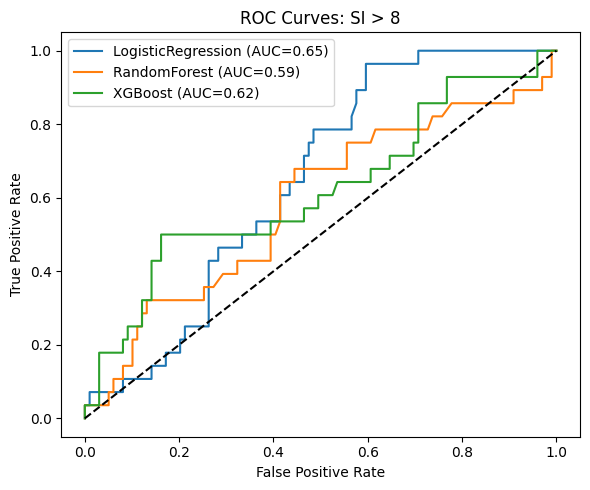

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# любые признаки-утечки: IC50, CC50 и их логарифмы, а также исходный SI
leakage_cols = [c for c in df.columns if any(key in c.upper() for key in ['IC50','CS50'])]
X = df.drop(columns=leakage_cols + ['SI'], errors='ignore')

#  SI > 8
y = (df['SI'] > 8).astype(int)

#  train/test (с стратификацией)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Функция для создания пайплайна
def make_pipeline(model):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler()),
        ('clf',     model)
    ])

# модели и их сетки гиперпараметров
models = {
    'LogisticRegression': {
        'pipeline': make_pipeline(LogisticRegression(random_state=42, solver='liblinear')),
        'params': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2']
        }
    },
    'RandomForest': {
        'pipeline': make_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1)),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__max_depth':    [None, 10, 20]
        }
    },
    'XGBoost': {
        'pipeline': make_pipeline(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
        'params': {
            'clf__n_estimators':    [100, 200],
            'clf__max_depth':       [3, 6],
            'clf__learning_rate':   [0.01, 0.1]
        }
    }
}

# GridSearchCV и оценка
results = []
for name, cfg in models.items():
    print(f"\n>>> Training {name}")
    gs = GridSearchCV(
        cfg['pipeline'],
        cfg['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)

    y_pred  = gs.predict(X_test)
    y_proba = gs.predict_proba(X_test)[:,1]

    results.append({
        'Model':        name,
        'BestParams':   gs.best_params_,
        'Accuracy':     accuracy_score(y_test, y_pred),
        'F1_score':     f1_score(y_test, y_pred),
        'ROC_AUC':      roc_auc_score(y_test, y_proba),
        'ConfusionMat': confusion_matrix(y_test, y_pred)
    })

# в табличном виде
import pandas as pd
res_df = pd.DataFrame(results).set_index('Model')
display(res_df)

# ROC-кривые
plt.figure(figsize=(6,5))
for r in results:
    proc_pipeline = models[r['Model']]['pipeline'].set_params(**r['BestParams'])
    proba = proc_pipeline.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{r['Model']} (AUC={r['ROC_AUC']:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: SI > 8')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
# Устанавливаем catboost
!pip install catboost --quiet


In [8]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute      import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline     import Pipeline
from sklearn.svm           import SVC
from catboost              import CatBoostClassifier
from sklearn.metrics       import roc_auc_score, f1_score, precision_recall_curve, classification_report, roc_curve
df = pd.read_csv('/content/dataset_for_SI_clean (1).csv')  # скорректируйте путь

# Убираем утечки
leaks = [c for c in df.columns if 'IC50' in c.upper() or 'CS50' in c.upper()]
X = df.drop(columns=leaks + ['SI'], errors='ignore')
y = (df['SI'] > 8).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Пайплайн с полиномами
def make_pipe(model):
    return Pipeline([
        ('imp',  SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

# Модели
models = {
    'SVM_balanced': make_pipe(
        SVC(probability=True, class_weight='balanced', random_state=42)
    ),
    'CatBoost': make_pipe(
        CatBoostClassifier(
            verbose=0,
            auto_class_weights='Balanced',
            random_state=42
        )
    )
}

# CV оценка
skf = StratifiedKFold(5, shuffle=True, random_state=42)
for name, pipe in models.items():
    auc = cross_val_score(pipe, X_train, y_train,
                          cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    f1  = cross_val_score(pipe, X_train, y_train,
                          cv=skf, scoring='f1', n_jobs=-1).mean()
    print(f"{name}: CV ROC_AUC={auc:.3f}, CV F1={f1:.3f}")

# Обучаем лучшую модель
best_pipe = models['CatBoost'].fit(X_train, y_train)
y_proba = best_pipe.predict_proba(X_test)[:,1]

#  по F1
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1s = 2*prec*rec/(prec+rec)
opt = np.argmax(f1s)
opt_thr = thr[opt]
print(f"Optimal threshold={opt_thr:.2f}, F1={f1s[opt]:.3f}")

# отчёт
y_pred = (y_proba > opt_thr).astype(int)
print(classification_report(y_test, y_pred))
print("Test ROC_AUC:", roc_auc_score(y_test, y_proba))

#ROC и PR кривые
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'CatBoost (AUC={roc_auc_score(y_test,y_proba):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label='Precision-Recall')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend()
plt.tight_layout(); plt.show()


SVM_balanced: CV ROC_AUC=0.569, CV F1=0.309


KeyboardInterrupt: 

In [11]:
import pandas as pd

# Сравнительная таблица моделей
data = {
    "Model": [
        "LogisticRegression",
        "RandomForest",
        "XGBoost",
        "SVM_balanced"
    ],
    "Accuracy": [
        0.732283,
        0.755906,
        0.763780,
        None  # Нет значения
    ],
    "F1_score": [
        0.150000,
        0.060606,
        0.250000,
        0.309000
    ],
    "ROC_AUC": [
        0.647367,
        0.586400,
        0.618146,
        0.569000
    ],
    "Confusion Matrix": [
        "[[90, 9], [25, 3]]",
        "[[95, 4], [27, 1]]",
        "[[92, 7], [23, 5]]",
        "—"
    ]
}

df = pd.DataFrame(data)

# Вывод таблицы с подсветкой
df.style.set_caption(" Сравнение моделей классификации") \
    .background_gradient(subset=["Accuracy"], cmap="Greens") \
    .background_gradient(subset=["F1_score"], cmap="Oranges") \
    .background_gradient(subset=["ROC_AUC"], cmap="Blues")


,Model,Accuracy,F1_score,ROC_AUC,Confusion Matrix
0,LogisticRegression,0.732283,0.150000,0.647367,"[[90, 9], [25, 3]]"
1,RandomForest,0.755906,0.060606,0.586400,"[[95, 4], [27, 1]]"
2,XGBoost,0.763780,0.250000,0.618146,"[[92, 7], [23, 5]]"
3,SVM_balanced,nan,0.309000,0.569000,—
